In [1]:
!maturin develop --release

🔗 Found pyo3 bindings
🐍 Found CPython 3.11 at /Users/josh/josh/projects/tech/riversim/.venv/bin/python
💻 Using `MACOSX_DEPLOYMENT_TARGET=10.7` for x86_64-apple-darwin by default
   --> src/geom.rs:547:5
    |
545 | pub struct Terrain {
    |            ------- field in this struct
546 |     /// Indexed by [`indexing::CellFootprintIndexing`]
547 |     centers: Array3,
    |     ^^^^^^^
    |
    = note: `Terrain` has a derived impl for the trait `Clone`, but this is intentionally ignored during dead code analysis
    = note: `#[warn(dead_code)]` on by default

    Finished release [optimized] target(s) in 0.21s
📦 Built wheel for CPython 3.11 to /var/folders/w9/c8qym84j2pg4fjvx_bzr84bc0000gn/T/.tmpKk4MeC/riversim-0.1.0-cp311-cp311-macosx_10_7_x86_64.whl
🛠 Installed riversim-0.1.0


 Cell index CellIndex { footprint: CellFootprintIndex { x: 0, y: 0, triangle: UpperLeft }, z: 0 }
  Vertical face CellVerticalFace { cell_index: CellIndex { footprint: CellFootprintIndex { x: 0, y: 0, triangle: UpperLeft }, z: 0 }, area: 0.025, outward_normal: [[0.0, 1.0, 0.0]], neighbor: Boundary(Upper) }
  Vertical face CellVerticalFace { cell_index: CellIndex { footprint: CellFootprintIndex { x: 0, y: 0, triangle: UpperLeft }, z: 0 }, area: 0.005, outward_normal: [[-1.0, -0.0, -0.0]], neighbor: Boundary(Left) }
  Vertical face CellVerticalFace { cell_index: CellIndex { footprint: CellFootprintIndex { x: 0, y: 0, triangle: UpperLeft }, z: 0 }, area: 0.025495097567963927, outward_normal: [[0.19611613513818402, -0.9805806756909201, 0.0]], neighbor: CellFootprint(CellFootprintIndex { x: 0, y: 0, triangle: LowerRight }) }
Cell footprint CellFootprintIndex { x: 0, y: 0, triangle: UpperLeft }, mass flux: 1.084e-19
 Cell index CellIndex { footprint: CellFootprintIndex { x: 0, y: 0, triangle

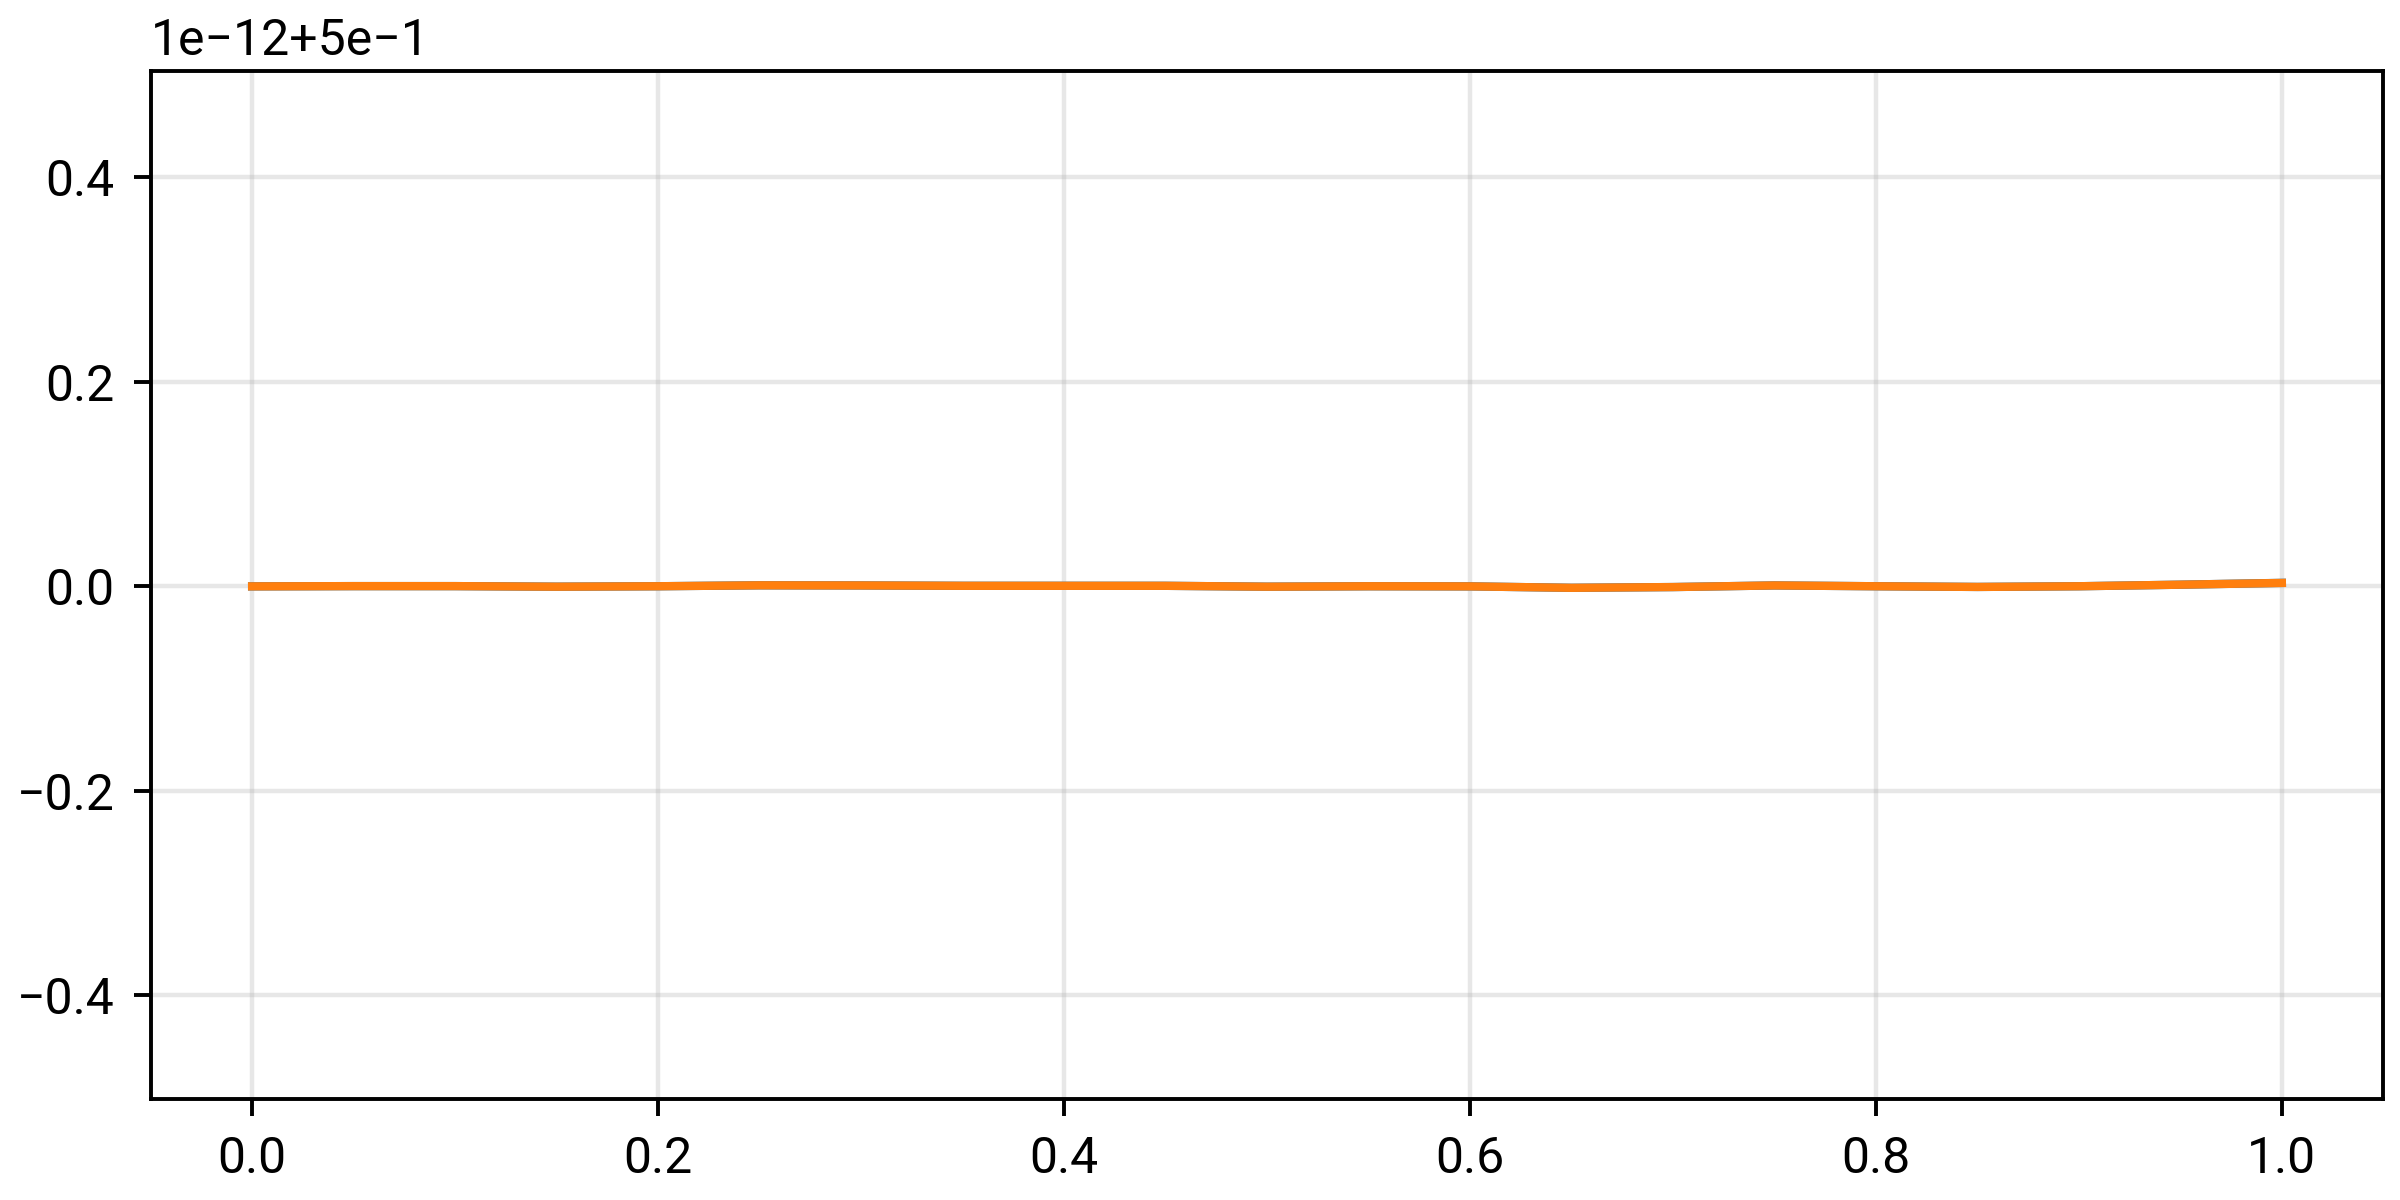

In [3]:
from joshpyutil import mpl

import riversim

solver = riversim.wave_1d(20, 2)
orig = solver.z_lattice[:, 0, -1]
for _ in range(1):
    solver.step(0.01)

with mpl.autoplot() as ap:
    ap.plot(solver.grid.x_axis.vertices, orig)
    ap.plot(solver.grid.x_axis.vertices, solver.z_lattice[:, 0, -1])